In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from catboost import CatBoostClassifier

from skopt import BayesSearchCV

from xgboost import XGBClassifier

%matplotlib inline

In [44]:
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

In [66]:
!ls data

aac_intakes.csv          df_dog.csv               master12218.csv
aac_intakes_outcomes.csv df_mod.csv               master_df.csv
aac_outcomes.csv         engineered.csv           master_df_1128.csv
all_categoricals.csv     group_shade.csv          master_df_1129.csv
concat_backup.csv        hour_ids.csv             model12218.csv
df_cat.csv               hr_name.csv


In [89]:
df_raw = pd.read_csv('./data/master12218.csv', index_col=0)

In [90]:
df_raw['datetime_in'] = pd.to_datetime(df_raw['datetime_in'])

In [91]:
df_raw['hour'] = df_raw['datetime_in'].dt.hour + (df_raw['datetime_in'].dt.minute/60.0)

In [92]:
df_raw = df_raw[~df_raw.duplicated()]

In [126]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64906 entries, 0 to 75010
Data columns (total 19 columns):
age                 64906 non-null int64
animal_type         64906 non-null object
days_in_shelter     64906 non-null int64
dow                 64906 non-null int64
fixed_status        64906 non-null object
gender              64906 non-null int64
group               64906 non-null object
intake_condition    64906 non-null object
intake_season       64906 non-null object
intake_type         64906 non-null object
mix                 64906 non-null int64
name                64906 non-null int64
outcome_type        64696 non-null object
simple_color        64906 non-null object
simple_group        64906 non-null object
shade               64906 non-null object
given_name          47196 non-null object
name_freq           64906 non-null int64
hour                64906 non-null float64
dtypes: float64(1), int64(7), object(11)
memory usage: 9.9+ MB


In [94]:
df_raw.drop(labels=['animal_id', 'datetime_in', 'hour_in'], axis=1, inplace=True)

In [95]:
df_raw.drop_duplicates(inplace=True)

In [118]:
df_raw.outcome_type.value_counts()

Adoption           29197
Transfer           20117
Return to Owner    12067
Euthanasia          2788
Died                 527
Rto-Adopt            147
Missing               41
Disposal              22
Name: outcome_type, dtype: int64

In [119]:
df_raw = df_raw[df_raw != 'Rto-Adopt']
df_raw = df_raw[df_raw != 'Missing']
df_raw = df_raw[df_raw != 'Disposal']

In [96]:
df = pd.read_csv('./data/model12218.csv', index_col = 0)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64339 entries, 0 to 75010
Data columns (total 18 columns):
age                 64339 non-null int64
animal_type         64339 non-null object
dow                 64339 non-null int64
fixed_status        64339 non-null object
gender              64339 non-null int64
group               64339 non-null object
intake_condition    64339 non-null object
intake_season       64339 non-null object
intake_type         64339 non-null object
mix                 64339 non-null int64
simple_color        64339 non-null object
hour_in             64339 non-null int64
simple_group        64339 non-null object
shade               64339 non-null object
given_name          47018 non-null object
name_freq           64339 non-null int64
days_in_shelter     64339 non-null int64
outcome_type        64339 non-null object
dtypes: int64(7), object(11)
memory usage: 9.3+ MB


In [98]:
df['gender'] = df['gender'].astype(str)

In [99]:
df['dow'] = df['dow'].astype(str)
df['mix'] = df['mix'].astype(str)
df['hour_in'] = df['hour_in'].astype(str)

In [100]:
df = df.drop(labels=['days_in_shelter'], axis=1)

In [101]:
df = df[~df.duplicated()]

In [102]:
df.reset_index(inplace=True, drop=True)

In [103]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [104]:
X = X.drop(labels=['given_name'], axis=1)

In [105]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [107]:
X.head()

,age,animal_type,dow,fixed_status,gender,group,intake_condition,intake_season,intake_type,mix,simple_color,hour_in,simple_group,shade,name_freq
0,2920,Dog,6,fixed,1,Sporting,Normal,summer,Stray,0,White,12,Sporting,Light,52
1,330,Dog,3,intact,0,Hound,Normal,spring,Stray,1,Sable,18,Non-Sporting,Light,1
2,1460,Dog,6,fixed,0,Working,Normal,spring,Stray,1,Yellow,10,Non-Sporting,Light,22
3,730,Dog,5,fixed,0,Sporting,Normal,winter,Owner Surrender,1,Brown,12,Sporting,Medium,32
4,730,Dog,3,intact,0,Sporting,Normal,summer,Public Assist,1,Black,14,Sporting,Dark,1


In [53]:
cat = CatBoostClassifier(cat_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

tuning_params = {'one_hot_max_size': [24], 'learning_rate': [1e-2, 1], 'loss_function': ['MultiClass'],
                 'depth': [6, 10], 'n_estimators': [800]}


bs = BayesSearchCV(cat, tuning_params, cv=3, verbose=True, scoring='neg_log_loss', n_jobs=-1, n_iter=10)

bs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 221.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.0min finished


0:	learn: -1.5773201	total: 146ms	remaining: 1m 56s
1:	learn: -1.5478636	total: 286ms	remaining: 1m 54s
2:	learn: -1.5202524	total: 449ms	remaining: 1m 59s
3:	learn: -1.4967671	total: 571ms	remaining: 1m 53s
4:	learn: -1.4729776	total: 722ms	remaining: 1m 54s
5:	learn: -1.4500967	total: 878ms	remaining: 1m 56s
6:	learn: -1.4285495	total: 1.02s	remaining: 1m 55s
7:	learn: -1.4086806	total: 1.17s	remaining: 1m 55s
8:	learn: -1.3898261	total: 1.31s	remaining: 1m 55s
9:	learn: -1.3716677	total: 1.46s	remaining: 1m 55s
10:	learn: -1.3537343	total: 1.6s	remaining: 1m 54s
11:	learn: -1.3378055	total: 1.72s	remaining: 1m 52s
12:	learn: -1.3217945	total: 1.87s	remaining: 1m 52s
13:	learn: -1.3078596	total: 1.98s	remaining: 1m 51s
14:	learn: -1.2931710	total: 2.14s	remaining: 1m 51s
15:	learn: -1.2791114	total: 2.28s	remaining: 1m 51s
16:	learn: -1.2663009	total: 2.38s	remaining: 1m 49s
17:	learn: -1.2538870	total: 2.52s	remaining: 1m 49s
18:	learn: -1.2414709	total: 2.67s	remaining: 1m 49s
19:	

155:	learn: -0.8861067	total: 21.3s	remaining: 1m 28s
156:	learn: -0.8859558	total: 21.4s	remaining: 1m 27s
157:	learn: -0.8855836	total: 21.6s	remaining: 1m 27s
158:	learn: -0.8854236	total: 21.7s	remaining: 1m 27s
159:	learn: -0.8851388	total: 21.8s	remaining: 1m 27s
160:	learn: -0.8848438	total: 22s	remaining: 1m 27s
161:	learn: -0.8846088	total: 22.1s	remaining: 1m 27s
162:	learn: -0.8843669	total: 22.3s	remaining: 1m 27s
163:	learn: -0.8841340	total: 22.4s	remaining: 1m 26s
164:	learn: -0.8838760	total: 22.6s	remaining: 1m 26s
165:	learn: -0.8836883	total: 22.7s	remaining: 1m 26s
166:	learn: -0.8833694	total: 22.8s	remaining: 1m 26s
167:	learn: -0.8831899	total: 22.9s	remaining: 1m 26s
168:	learn: -0.8829534	total: 23.1s	remaining: 1m 26s
169:	learn: -0.8827521	total: 23.2s	remaining: 1m 26s
170:	learn: -0.8824625	total: 23.4s	remaining: 1m 25s
171:	learn: -0.8821417	total: 23.5s	remaining: 1m 25s
172:	learn: -0.8819275	total: 23.7s	remaining: 1m 25s
173:	learn: -0.8814485	total: 

309:	learn: -0.8627793	total: 41.6s	remaining: 1m 5s
310:	learn: -0.8626684	total: 41.7s	remaining: 1m 5s
311:	learn: -0.8624559	total: 41.9s	remaining: 1m 5s
312:	learn: -0.8622844	total: 42s	remaining: 1m 5s
313:	learn: -0.8621273	total: 42.2s	remaining: 1m 5s
314:	learn: -0.8620309	total: 42.3s	remaining: 1m 5s
315:	learn: -0.8619549	total: 42.4s	remaining: 1m 4s
316:	learn: -0.8619037	total: 42.5s	remaining: 1m 4s
317:	learn: -0.8617289	total: 42.6s	remaining: 1m 4s
318:	learn: -0.8616206	total: 42.8s	remaining: 1m 4s
319:	learn: -0.8615474	total: 42.9s	remaining: 1m 4s
320:	learn: -0.8614487	total: 43.1s	remaining: 1m 4s
321:	learn: -0.8613791	total: 43.2s	remaining: 1m 4s
322:	learn: -0.8612374	total: 43.4s	remaining: 1m 4s
323:	learn: -0.8611377	total: 43.5s	remaining: 1m 3s
324:	learn: -0.8610079	total: 43.6s	remaining: 1m 3s
325:	learn: -0.8609306	total: 43.8s	remaining: 1m 3s
326:	learn: -0.8608145	total: 43.9s	remaining: 1m 3s
327:	learn: -0.8607382	total: 44.1s	remaining: 1

467:	learn: -0.8503663	total: 1m 3s	remaining: 45.2s
468:	learn: -0.8503374	total: 1m 3s	remaining: 45s
469:	learn: -0.8503120	total: 1m 3s	remaining: 44.9s
470:	learn: -0.8502146	total: 1m 4s	remaining: 44.8s
471:	learn: -0.8501909	total: 1m 4s	remaining: 44.6s
472:	learn: -0.8501459	total: 1m 4s	remaining: 44.5s
473:	learn: -0.8501259	total: 1m 4s	remaining: 44.3s
474:	learn: -0.8500890	total: 1m 4s	remaining: 44.2s
475:	learn: -0.8500053	total: 1m 4s	remaining: 44s
476:	learn: -0.8498777	total: 1m 4s	remaining: 43.9s
477:	learn: -0.8498129	total: 1m 4s	remaining: 43.8s
478:	learn: -0.8496973	total: 1m 5s	remaining: 43.7s
479:	learn: -0.8496307	total: 1m 5s	remaining: 43.5s
480:	learn: -0.8495427	total: 1m 5s	remaining: 43.4s
481:	learn: -0.8493988	total: 1m 5s	remaining: 43.3s
482:	learn: -0.8492228	total: 1m 5s	remaining: 43.2s
483:	learn: -0.8491927	total: 1m 6s	remaining: 43.1s
484:	learn: -0.8491495	total: 1m 6s	remaining: 43s
485:	learn: -0.8491230	total: 1m 6s	remaining: 42.8s

621:	learn: -0.8405815	total: 1m 24s	remaining: 24.3s
622:	learn: -0.8405726	total: 1m 25s	remaining: 24.2s
623:	learn: -0.8404650	total: 1m 25s	remaining: 24s
624:	learn: -0.8403579	total: 1m 25s	remaining: 23.9s
625:	learn: -0.8402878	total: 1m 25s	remaining: 23.8s
626:	learn: -0.8402379	total: 1m 25s	remaining: 23.6s
627:	learn: -0.8401935	total: 1m 25s	remaining: 23.5s
628:	learn: -0.8401028	total: 1m 25s	remaining: 23.4s
629:	learn: -0.8399957	total: 1m 26s	remaining: 23.2s
630:	learn: -0.8399002	total: 1m 26s	remaining: 23.1s
631:	learn: -0.8398546	total: 1m 26s	remaining: 23s
632:	learn: -0.8398179	total: 1m 26s	remaining: 22.8s
633:	learn: -0.8397348	total: 1m 26s	remaining: 22.7s
634:	learn: -0.8396791	total: 1m 26s	remaining: 22.6s
635:	learn: -0.8396548	total: 1m 26s	remaining: 22.4s
636:	learn: -0.8396196	total: 1m 27s	remaining: 22.3s
637:	learn: -0.8395945	total: 1m 27s	remaining: 22.2s
638:	learn: -0.8395301	total: 1m 27s	remaining: 22s
639:	learn: -0.8394411	total: 1m 2

775:	learn: -0.8328205	total: 1m 47s	remaining: 3.31s
776:	learn: -0.8327663	total: 1m 47s	remaining: 3.17s
777:	learn: -0.8327079	total: 1m 47s	remaining: 3.04s
778:	learn: -0.8326295	total: 1m 47s	remaining: 2.9s
779:	learn: -0.8324949	total: 1m 47s	remaining: 2.76s
780:	learn: -0.8324432	total: 1m 47s	remaining: 2.62s
781:	learn: -0.8324076	total: 1m 47s	remaining: 2.48s
782:	learn: -0.8323436	total: 1m 48s	remaining: 2.35s
783:	learn: -0.8322906	total: 1m 48s	remaining: 2.21s
784:	learn: -0.8322506	total: 1m 48s	remaining: 2.07s
785:	learn: -0.8321909	total: 1m 48s	remaining: 1.93s
786:	learn: -0.8321634	total: 1m 48s	remaining: 1.79s
787:	learn: -0.8321277	total: 1m 48s	remaining: 1.66s
788:	learn: -0.8321135	total: 1m 48s	remaining: 1.52s
789:	learn: -0.8320316	total: 1m 49s	remaining: 1.38s
790:	learn: -0.8319632	total: 1m 49s	remaining: 1.24s
791:	learn: -0.8319192	total: 1m 49s	remaining: 1.1s
792:	learn: -0.8318776	total: 1m 49s	remaining: 967ms
793:	learn: -0.8318328	total: 

BayesSearchCV(cv=3, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x11674bc50>,
       fit_params=None, iid=True, n_iter=10, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='neg_log_loss',
       search_spaces={'one_hot_max_size': [24], 'learning_rate': [0.01, 1], 'loss_function': ['MultiClass'], 'depth': [6, 10], 'n_estimators': [800]},
       verbose=True)

In [54]:
bs.best_score_

-0.8682877193318085

In [55]:
bs.best_params_

{'depth': 8,
 'learning_rate': 0.022944294136017482,
 'loss_function': 'MultiClass',
 'n_estimators': 800,
 'one_hot_max_size': 24}

In [57]:
cat_boost = CatBoostClassifier(cat_features=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                               depth=8, learning_rate = .023, loss_function='MultiClass',
                               n_estimators = 800, one_hot_max_size=24)

scores = cross_val_score(cat_boost, X_train, y_train, cv=3, n_jobs=-1, scoring='neg_log_loss')

In [59]:
cat_boost.fit(X_train, y_train)

0:	learn: -1.5772430	total: 155ms	remaining: 2m 3s
1:	learn: -1.5477211	total: 292ms	remaining: 1m 56s
2:	learn: -1.5200531	total: 435ms	remaining: 1m 55s
3:	learn: -1.4965225	total: 542ms	remaining: 1m 47s
4:	learn: -1.4726901	total: 708ms	remaining: 1m 52s
5:	learn: -1.4497711	total: 874ms	remaining: 1m 55s
6:	learn: -1.4281907	total: 1.03s	remaining: 1m 56s
7:	learn: -1.4082929	total: 1.18s	remaining: 1m 56s
8:	learn: -1.3894130	total: 1.32s	remaining: 1m 56s
9:	learn: -1.3712317	total: 1.46s	remaining: 1m 55s
10:	learn: -1.3532773	total: 1.61s	remaining: 1m 55s
11:	learn: -1.3373314	total: 1.73s	remaining: 1m 53s
12:	learn: -1.3213045	total: 1.87s	remaining: 1m 53s
13:	learn: -1.3073568	total: 1.98s	remaining: 1m 50s
14:	learn: -1.2926561	total: 2.13s	remaining: 1m 51s
15:	learn: -1.2785854	total: 2.27s	remaining: 1m 51s
16:	learn: -1.2657664	total: 2.4s	remaining: 1m 50s
17:	learn: -1.2533449	total: 2.55s	remaining: 1m 50s
18:	learn: -1.2409221	total: 2.71s	remaining: 1m 51s
19:	l

156:	learn: -0.8858823	total: 22.2s	remaining: 1m 30s
157:	learn: -0.8855241	total: 22.4s	remaining: 1m 30s
158:	learn: -0.8852474	total: 22.5s	remaining: 1m 30s
159:	learn: -0.8849970	total: 22.6s	remaining: 1m 30s
160:	learn: -0.8847575	total: 22.8s	remaining: 1m 30s
161:	learn: -0.8845092	total: 22.9s	remaining: 1m 30s
162:	learn: -0.8842965	total: 23s	remaining: 1m 30s
163:	learn: -0.8840365	total: 23.2s	remaining: 1m 29s
164:	learn: -0.8837538	total: 23.3s	remaining: 1m 29s
165:	learn: -0.8832735	total: 23.4s	remaining: 1m 29s
166:	learn: -0.8831538	total: 23.5s	remaining: 1m 29s
167:	learn: -0.8829140	total: 23.7s	remaining: 1m 29s
168:	learn: -0.8827131	total: 23.8s	remaining: 1m 28s
169:	learn: -0.8824226	total: 24s	remaining: 1m 28s
170:	learn: -0.8821029	total: 24.1s	remaining: 1m 28s
171:	learn: -0.8818825	total: 24.3s	remaining: 1m 28s
172:	learn: -0.8816381	total: 24.4s	remaining: 1m 28s
173:	learn: -0.8813852	total: 24.5s	remaining: 1m 28s
174:	learn: -0.8812429	total: 24

310:	learn: -0.8633073	total: 42.4s	remaining: 1m 6s
311:	learn: -0.8631813	total: 42.6s	remaining: 1m 6s
312:	learn: -0.8631201	total: 42.7s	remaining: 1m 6s
313:	learn: -0.8630455	total: 42.8s	remaining: 1m 6s
314:	learn: -0.8629511	total: 43s	remaining: 1m 6s
315:	learn: -0.8628859	total: 43.1s	remaining: 1m 6s
316:	learn: -0.8627756	total: 43.3s	remaining: 1m 5s
317:	learn: -0.8626475	total: 43.4s	remaining: 1m 5s
318:	learn: -0.8624505	total: 43.6s	remaining: 1m 5s
319:	learn: -0.8623808	total: 43.7s	remaining: 1m 5s
320:	learn: -0.8622693	total: 43.8s	remaining: 1m 5s
321:	learn: -0.8622220	total: 44s	remaining: 1m 5s
322:	learn: -0.8621192	total: 44.1s	remaining: 1m 5s
323:	learn: -0.8620377	total: 44.3s	remaining: 1m 5s
324:	learn: -0.8618312	total: 44.4s	remaining: 1m 4s
325:	learn: -0.8617206	total: 44.5s	remaining: 1m 4s
326:	learn: -0.8616232	total: 44.7s	remaining: 1m 4s
327:	learn: -0.8614630	total: 44.8s	remaining: 1m 4s
328:	learn: -0.8613450	total: 44.9s	remaining: 1m 

468:	learn: -0.8507870	total: 1m 4s	remaining: 45.2s
469:	learn: -0.8506809	total: 1m 4s	remaining: 45.1s
470:	learn: -0.8506054	total: 1m 4s	remaining: 44.9s
471:	learn: -0.8504846	total: 1m 4s	remaining: 44.8s
472:	learn: -0.8504001	total: 1m 4s	remaining: 44.7s
473:	learn: -0.8502817	total: 1m 4s	remaining: 44.5s
474:	learn: -0.8500923	total: 1m 4s	remaining: 44.4s
475:	learn: -0.8499839	total: 1m 5s	remaining: 44.3s
476:	learn: -0.8499487	total: 1m 5s	remaining: 44.2s
477:	learn: -0.8499265	total: 1m 5s	remaining: 44s
478:	learn: -0.8498928	total: 1m 5s	remaining: 43.9s
479:	learn: -0.8497743	total: 1m 5s	remaining: 43.8s
480:	learn: -0.8496860	total: 1m 5s	remaining: 43.6s
481:	learn: -0.8495682	total: 1m 5s	remaining: 43.5s
482:	learn: -0.8494370	total: 1m 6s	remaining: 43.4s
483:	learn: -0.8494004	total: 1m 6s	remaining: 43.3s
484:	learn: -0.8493121	total: 1m 6s	remaining: 43.1s
485:	learn: -0.8492406	total: 1m 6s	remaining: 43s
486:	learn: -0.8492039	total: 1m 6s	remaining: 42.

622:	learn: -0.8405911	total: 1m 26s	remaining: 24.7s
623:	learn: -0.8405555	total: 1m 27s	remaining: 24.6s
624:	learn: -0.8404950	total: 1m 27s	remaining: 24.4s
625:	learn: -0.8404467	total: 1m 27s	remaining: 24.3s
626:	learn: -0.8403560	total: 1m 27s	remaining: 24.2s
627:	learn: -0.8402905	total: 1m 27s	remaining: 24s
628:	learn: -0.8402268	total: 1m 27s	remaining: 23.9s
629:	learn: -0.8401981	total: 1m 27s	remaining: 23.7s
630:	learn: -0.8401642	total: 1m 28s	remaining: 23.6s
631:	learn: -0.8400516	total: 1m 28s	remaining: 23.5s
632:	learn: -0.8399402	total: 1m 28s	remaining: 23.3s
633:	learn: -0.8398283	total: 1m 28s	remaining: 23.2s
634:	learn: -0.8397869	total: 1m 28s	remaining: 23.1s
635:	learn: -0.8397192	total: 1m 28s	remaining: 22.9s
636:	learn: -0.8396822	total: 1m 29s	remaining: 22.8s
637:	learn: -0.8396278	total: 1m 29s	remaining: 22.7s
638:	learn: -0.8396013	total: 1m 29s	remaining: 22.5s
639:	learn: -0.8395935	total: 1m 29s	remaining: 22.4s
640:	learn: -0.8395640	total: 

776:	learn: -0.8324337	total: 1m 50s	remaining: 3.26s
777:	learn: -0.8324133	total: 1m 50s	remaining: 3.12s
778:	learn: -0.8323756	total: 1m 50s	remaining: 2.97s
779:	learn: -0.8323126	total: 1m 50s	remaining: 2.83s
780:	learn: -0.8322733	total: 1m 50s	remaining: 2.69s
781:	learn: -0.8322122	total: 1m 50s	remaining: 2.55s
782:	learn: -0.8322102	total: 1m 50s	remaining: 2.41s
783:	learn: -0.8321827	total: 1m 51s	remaining: 2.27s
784:	learn: -0.8321423	total: 1m 51s	remaining: 2.12s
785:	learn: -0.8321017	total: 1m 51s	remaining: 1.98s
786:	learn: -0.8320319	total: 1m 51s	remaining: 1.84s
787:	learn: -0.8319882	total: 1m 51s	remaining: 1.7s
788:	learn: -0.8319444	total: 1m 51s	remaining: 1.56s
789:	learn: -0.8319242	total: 1m 51s	remaining: 1.42s
790:	learn: -0.8318923	total: 1m 52s	remaining: 1.27s
791:	learn: -0.8318555	total: 1m 52s	remaining: 1.13s
792:	learn: -0.8317989	total: 1m 52s	remaining: 992ms
793:	learn: -0.8317648	total: 1m 52s	remaining: 850ms
794:	learn: -0.8317081	total:

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

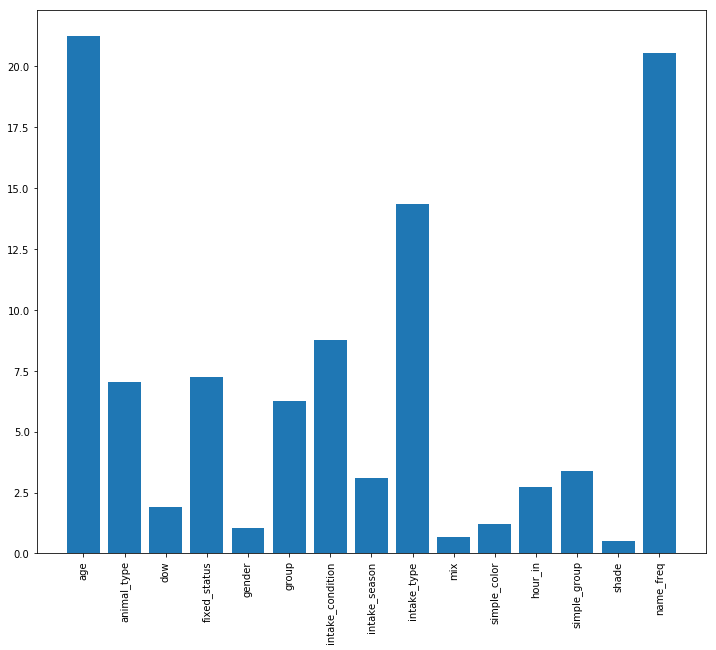

In [65]:
plt.figure(figsize=(12, 10))
plt.bar(X_train.columns, cat_boost.feature_importances_)
plt.xticks(rotation=90)

## Catboost with hour+minute data

In [134]:
df_raw['outcome_type'] = df_raw['outcome_type'].astype(str)

In [135]:
X = df_raw.drop(labels=['outcome_type', 'given_name', 'days_in_shelter'], axis=1)
y = df_raw['outcome_type']

le = LabelEncoder()
le.fit(y)
y = le.transform(y.fillna('0'))

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [136]:
X_train.columns.values

array(['age', 'animal_type', 'dow', 'fixed_status', 'gender', 'group',
       'intake_condition', 'intake_season', 'intake_type', 'mix', 'name',
       'simple_color', 'simple_group', 'shade', 'name_freq', 'hour'],
      dtype=object)

In [137]:
cat_boost = CatBoostClassifier(cat_features=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                               depth=8, learning_rate = .023, loss_function='MultiClass',
                               n_estimators = 800, one_hot_max_size=24)

scores = cross_val_score(cat_boost, X_train, y_train, cv=3, n_jobs=-1, scoring='neg_log_loss')

In [138]:
scores

array([-0.87345825, -0.88395929, -0.87502304])